# Calculating the power spectrum for masked images

In this notebook, we will implement a mehtod by Arévalo et al. 2012[https://ui.adsabs.harvard.edu/abs/2012MNRAS.426.1793A/] for calculating the power spectrum of images with masked regions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
from scipy import fft
from scipy.stats import binned_statistic

## First, we will generate a synthetic image with a given power spectrum

In [2]:
# Number of points in the image
npoints = 256

# Spacing between pixels, which can be used to transform the pixel size into other length scale
d = 1

# A meshgrid for kx and ky
Kx, Ky = np.meshgrid(np.fft.fftfreq(npoints, d), np.fft.fftfreq(npoints, d))

## There are a few options here. 
### (a) Power-law

In [3]:
# Power-law power spectrum
p = -2 # power-law index
K = np.sqrt(Kx*Kx+Ky*Ky)
G = K**(p)

theta = 2*np.pi*np.random.rand(*K.shape)
G = G*(np.cos(theta) + 1j*np.sin(theta))

# The edge point will be infinity (since kx and ky are 0) and need to be manually fixed
G[0,0] = 0

/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


### (b) Gaussian


In [4]:
#mean = 50/npoints
#sigma = 100/npoints
#G = np.exp(-((np.abs(Kx)-mean)**2+(np.abs(Ky)-mean)**2)/2/sigma/sigma)

#theta = 2*np.pi*np.random.rand(*K.shape)
#G = G*(np.cos(theta) + 1j*np.sin(theta))

Take a look of the image in fourier space

/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


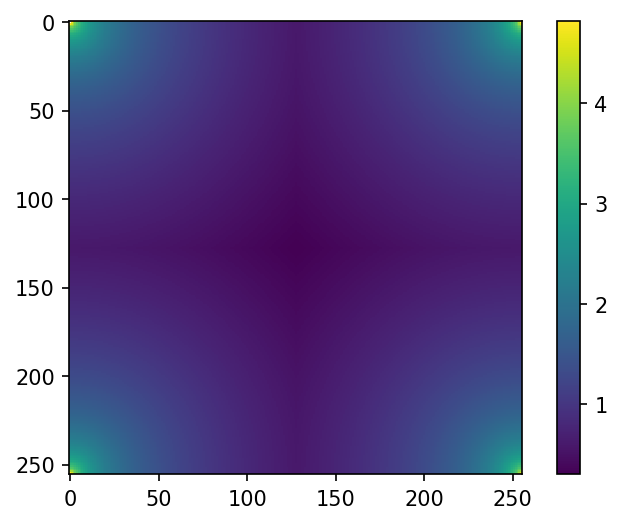

In [5]:
plt.imshow(np.log10(np.abs(G)))
plt.colorbar()

And plot the power spectrum

[]

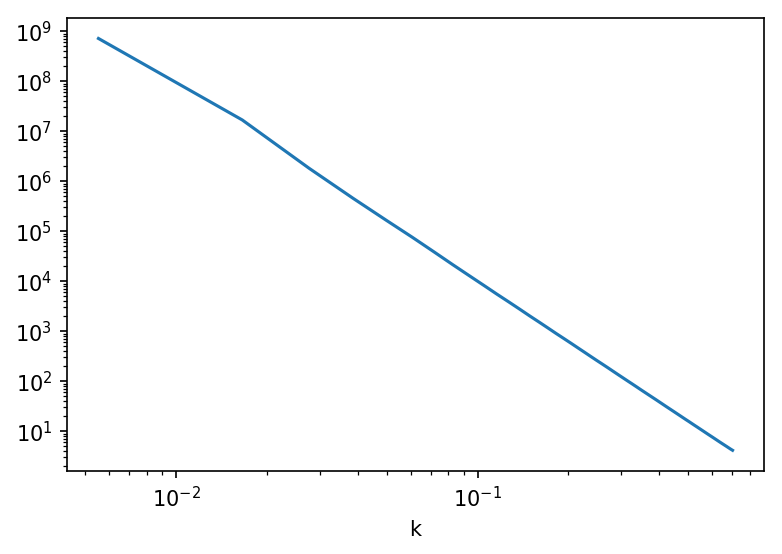

In [6]:
K = np.sqrt(Kx*Kx+Ky*Ky)
stat = binned_statistic(K.flatten(), np.abs(G).flatten(), bins=64, statistic='mean')
bin_center = (stat.bin_edges[:-1]+stat.bin_edges[1:])/2
plt.plot(bin_center, stat.statistic**2)
plt.semilogx()
plt.xlabel('k')
plt.semilogy()

Now we take the inverse Fourier transfor to get the synthetic image

In [7]:
# Take the inverse Fourier transform
F = np.fft.ifft2(G)

In [8]:
# F is a complex array
F

array([[ 1.09378883+0.99842939j,  1.06028448+1.05690239j,
         1.00092456+1.09144125j, ...,  1.18548272+0.71528261j,
         1.18052666+0.81932786j,  1.15147188+0.91257898j],
       [ 1.05954228+1.02284033j,  1.02467203+1.03740111j,
         0.95893570+1.09279686j, ...,  1.17468180+0.81395274j,
         1.13215292+0.87336594j,  1.11786800+0.97687964j],
       [ 1.05163496+1.02953823j,  1.03728598+1.03552934j,
         0.96667854+1.06017923j, ...,  1.13397361+0.89389377j,
         1.09701071+0.92346322j,  1.08492171+0.98283225j],
       ..., 
       [ 1.22066499+0.92005435j,  1.17033698+0.95993597j,
         1.16713463+1.00968798j, ...,  1.16245515+0.69377319j,
         1.17655666+0.76227711j,  1.23313015+0.8290994j ],
       [ 1.20358971+0.94842538j,  1.19700038+0.97509226j,
         1.10358196+1.022237j  , ...,  1.19402456+0.61611937j,
         1.21449514+0.71481167j,  1.22482899+0.82733558j],
       [ 1.16752721+0.99420093j,  1.08521089+1.03611344j,
         1.00780409+1.0694122

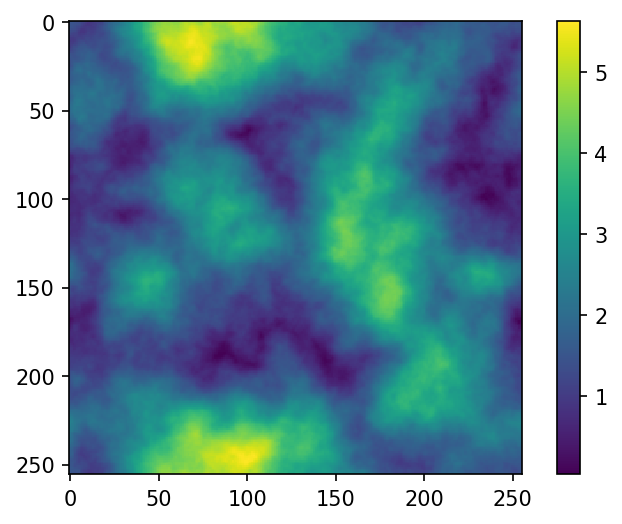

In [9]:
plt.imshow(np.abs(F))
plt.colorbar()

We will take the absolute value of each pixel as the image. You can also try taking the real or the imaginary part.

In [10]:
#img = (np.abs(F))/(np.abs(F).max()-np.abs(F).min())
#img = np.real(F)
img = np.abs(F)

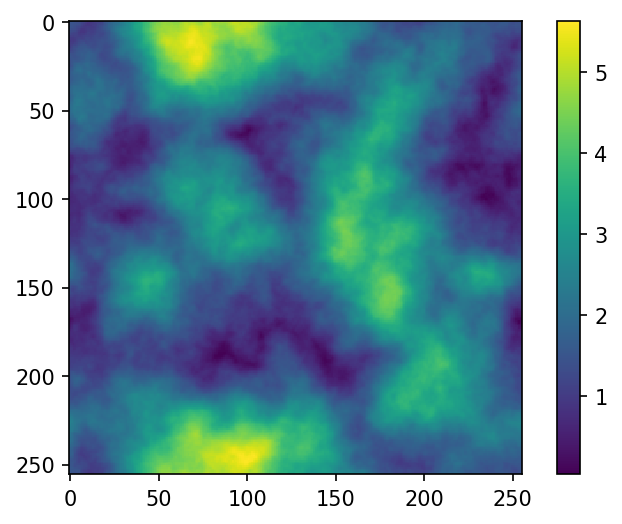

In [11]:
plt.imshow(img)
plt.colorbar()

In [12]:
def get_power_spectrum(img):
    from scipy.stats import binned_statistic
    
    # Take the Fourier transform to get the image in k space
    img_k = np.fft.fft2(img)
    
    # Set up the kx and ky array
    kx, ky = np.fft.fftfreq(img.shape[0]), np.fft.fftfreq(img.shape[1])
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2+ky**2)

    # Calculate the mean of the img_k in each bin
    stat = binned_statistic(k.flatten(), np.abs(img_k).flatten(), bins=64, statistic='mean')
    bin_center = (stat.bin_edges[:-1]+stat.bin_edges[1:])/2 
    
    return bin_center, stat.statistic**2, stat.binnumber

### Set up a masked image

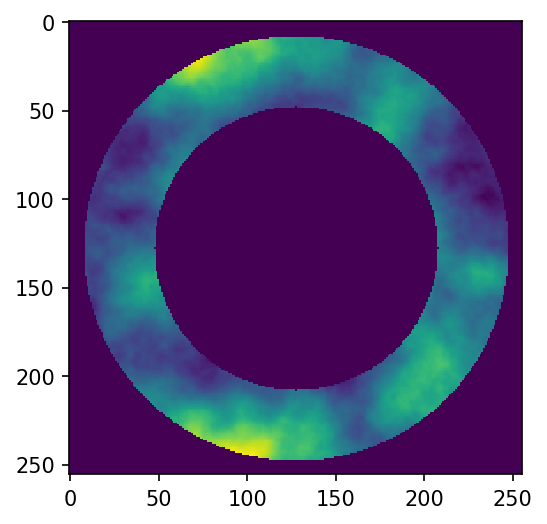

In [13]:
X, Y = np.meshgrid(range(img.shape[0]), range(img.shape[1]))

center = [img.shape[0]/2, img.shape[1]/2]
R1 = 80
R2 = 120

#mask = np.logical_and(X>100, Y>100)
mask = np.logical_and( ((X-center[0])**2+(Y-center[1])**2)>R1**2, ((X-center[0])**2+(Y-center[1])**2)<R2**2 )
#mask = np.logical_and( X+Y<250, X-Y>-50 )
masked_img = img.copy()
masked_img[~mask] = 0
plt.imshow(masked_img)

### Calculate the power spectra for the full image and the masked image

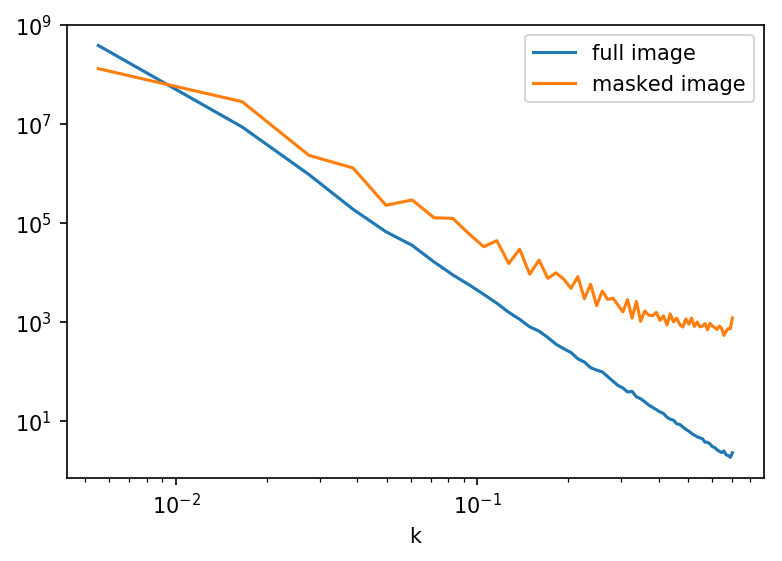

In [14]:
bin_center, power, numbers = get_power_spectrum(img)
plt.plot(bin_center, power, label='full image')

bin_center, power, numbers = get_power_spectrum(masked_img)
plt.plot(bin_center, power, label='masked image')
plt.legend()
plt.semilogy()
plt.semilogx()
plt.xlabel('k')

The power spectrum of the masked image has more power, especially for large k. This is likely due to the sharp edges of the mask.

## Variance to correct the power spectrum
Now we will implement the variance method, trying to remove the effect of the mask on the power spectra.

The steps can be summarized as
1. The original image is convolved with two filters (e.g. Gaussian) having different smoothing lengths $\sigma_1 = \sigma/\sqrt{1+\epsilon}$ and $\sigma_1 = \sigma\sqrt{1+\epsilon}$, where $\epsilon << 1.$
2. Convolved images are corrected for the data gaps
3. The difference of two images is calculated. This difference image is dominated by fluctuations at scales $\sim \sigma$.
4. The variance of the resulting image is calculated and recasted into an estimate of the power.

In [15]:
def get_power_spectrum_variance_method(img, ks, mask=None):
    from astropy.convolution import convolve_fft, Gaussian2DKernel
    P = np.zeros(len(ks))

    epsilon = 0.001

    for i, k in enumerate(ks):
        
        # The peak of the filter power is at kr = 0.225/σ and its width is ∼1.155 kr.
        sigma = 0.225/k
        
        # Create a full domain mask if there is no mask or the shape does not match
        if mask is None or mask.shape != img.shape:
            mask = np.ones(img.shape)
        
        # Convolve the image and the mask with the first Gaussian kernel
        G1 = Gaussian2DKernel(sigma/np.sqrt(1+epsilon))
        convolved_img1 = convolve_fft(img, G1)
        convolved_mask1 = convolve_fft(mask, G1)
        
        # Convolve the image and the mask with the second Gaussian kernel, which has a slightly larger width
        G2 = Gaussian2DKernel(sigma*np.sqrt(1+epsilon))
        convolved_img2 = convolve_fft(img, G2)
        convolved_mask2 = convolve_fft(mask, G2)
        
        # The difference of the convolved image corrected for the mask
        S = np.nan_to_num((convolved_img1/convolved_mask1-convolved_img2/convolved_mask2)*mask)
        
        # Take the square of the image and sum. 
        # Scale according to the ratio of total pixels of the image to that of the mask.
        V = np.sum(np.ones(img.shape))/np.sum(mask)*np.sum(S**2)
        
        # Convert the power to correct scale
        P[i] = V/epsilon**2/k**2/np.pi

    return P

### Apply this method to the full image and the masked image
This might take a while to run, depending on the number of sampling in k space

/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract


[]

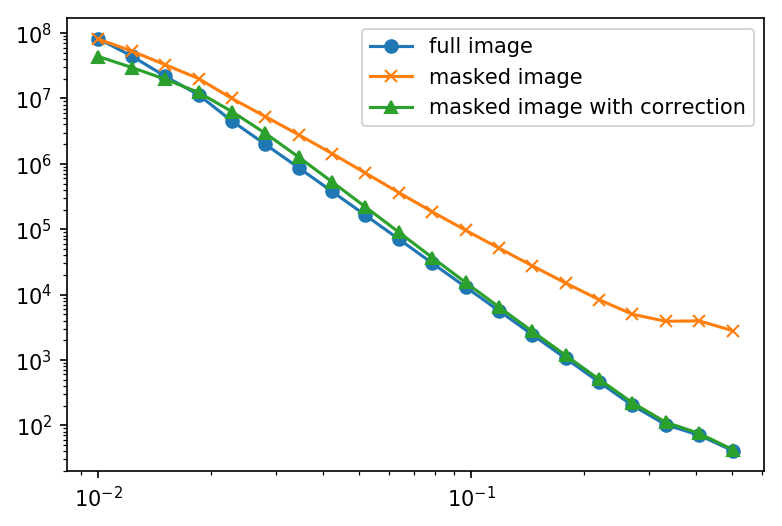

In [16]:
ks = np.logspace(-2, -0.3, 20)
V = get_power_spectrum_variance_method(img, ks)
plt.plot(ks, V, 'o-', label='full image')

V_masked = get_power_spectrum_variance_method(masked_img, ks)
plt.plot(ks, V_masked, 'x-', label='masked image')

V_masked2 = get_power_spectrum_variance_method(masked_img, ks, mask=mask)
plt.plot(ks, V_masked2, '^-', label='masked image with correction')

plt.legend()
plt.semilogx()
plt.semilogy()

We can clearly see that this method does recover the power spectrum of the full image. Of course, the uncertainty of the power spectrum from the masked image will be larger, which is not considered here.